In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Helpful Functions

In [2]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,tensorflow_hub as hub
import pylab as pl,numpy as np
file_path='https://olgabelitskaya.gitlab.io/images/'
img_size=50

In [3]:
%radial_gradient_header Image Data for Super Resolution

In [4]:
def get_resize_img(img_path,img_size=50):
    img_path=tf.keras.utils.get_file(
        'img'+str(np.random.randint(1,99999))+'.png',img_path)
    lr=tf.io.read_file(img_path)
    lr=tf.image.decode_jpeg(lr)
    print('mean: %f'%lr.numpy().mean())
    lr=tf.image.resize(lr,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
    return tf.cast(lr,tf.float32)

In [5]:
file_name1='04_001.png'
lr10=get_resize_img(file_path+file_name1,img_size)
file_name2='01_019.png'
lr20=get_resize_img(file_path+file_name2,img_size)
lr10.shape,lr20.shape

16384/12115 [========================================] - 0s 0us/step
mean: 217.956726
352256/351359 [==============================] - 0s 1us/step
mean: 144.307845


(TensorShape([1, 50, 50, 3]), TensorShape([1, 50, 50, 3]))

In [6]:
%radial_gradient_header Model Applying

In [7]:
def esrgantf2_superresolution(lr):
    if len(lr.shape)<4:
        lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
    lr=tf.cast(lr,tf.float32)
    img_size=lr.shape[1]
    model=hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[0].set_shape([1,img_size,img_size,3])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[0]['index'])
    sr=tf.squeeze(output_data,axis=0)
    sr=tf.round(tf.clip_by_value(sr,0,255)) 
    sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)
    return lr,sr

In [8]:
lr11,sr11=esrgantf2_superresolution(lr10)
lr11.shape,sr11.shape

(TensorShape([50, 50, 3]), TensorShape([200, 200, 3]))

In [9]:
lr12,sr12=esrgantf2_superresolution(sr11)
lr12.shape,sr12.shape

(TensorShape([200, 200, 3]), TensorShape([800, 800, 3]))

In [10]:
lr21,sr21=esrgantf2_superresolution(lr20)
lr21.shape,sr21.shape

(TensorShape([50, 50, 3]), TensorShape([200, 200, 3]))

In [11]:
lr22,sr22=esrgantf2_superresolution(sr21)
lr22.shape,sr22.shape

(TensorShape([200, 200, 3]), TensorShape([800, 800, 3]))

In [12]:
%radial_gradient_header Visual Results of Super Resolution

In [13]:
def low2bicubic_low2super(lr0,sr1,sr2,fig_size=4):
    img_size=lr0.shape[1]
    lr0=tf.cast(tf.squeeze(lr0,axis=0),tf.uint8)
    pl.figure(figsize=(3*fig_size,fig_size))
    pl.subplot(1,3,1); pl.title('LR0')
    pl.imshow(lr0.numpy())
    bicubic4=tf.image.resize(
        lr0,[img_size*4,img_size*4],
        tf.image.ResizeMethod.BICUBIC)
    bicubic4=tf.cast(bicubic4,tf.uint8)
    pl.subplot(1,3,2); pl.title(f'Bicubic x4')
    pl.imshow(bicubic4.numpy())
    bicubic16=tf.image.resize(
        bicubic4,[img_size*16,img_size*16],
        tf.image.ResizeMethod.BICUBIC)
    bicubic16=tf.cast(bicubic16,tf.uint8)
    pl.subplot(1,3,3); pl.title(f'Bicubic x16')
    pl.imshow(bicubic16.numpy())
    pl.tight_layout(); pl.show()
    pl.figure(figsize=(3*fig_size,fig_size))
    pl.subplot(1,3,1); pl.title('LR0')
    pl.imshow(lr0.numpy())   
    pl.subplot(1,3,2); pl.title(f'ESRGAN x4')
    pl.imshow(sr1.numpy())
    pl.subplot(1,3,3); pl.title(f'ESRGAN x16')
    pl.imshow(sr2.numpy())
    pl.tight_layout(); pl.show()

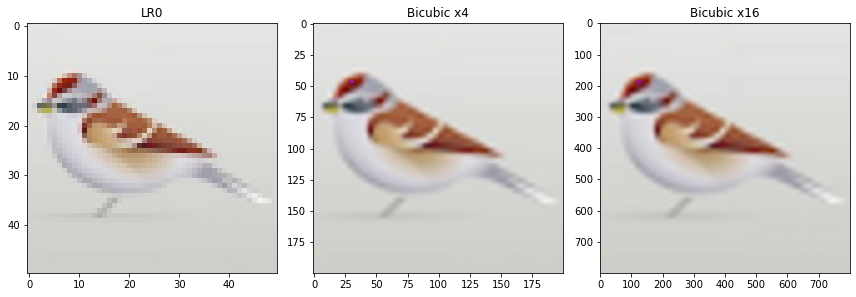

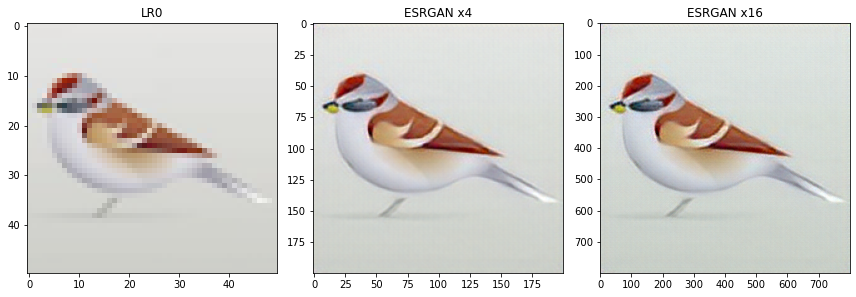

In [14]:
low2bicubic_low2super(lr10,sr11,sr12) 

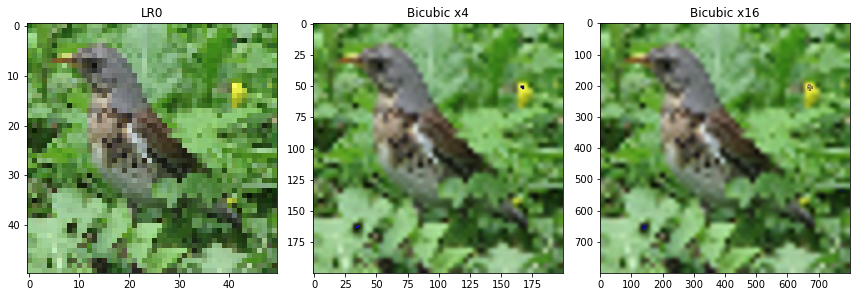

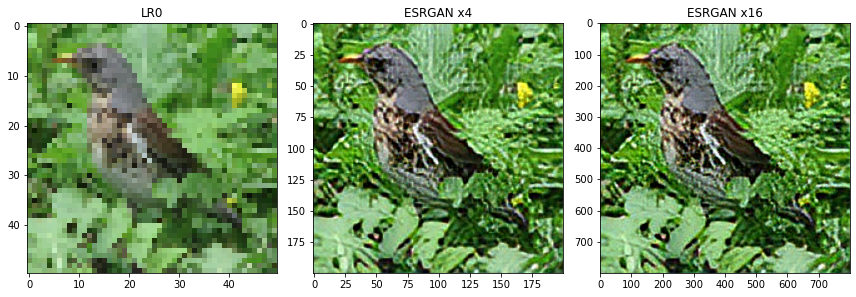

In [15]:
low2bicubic_low2super(lr20,sr21,sr22)

In [16]:
%radial_gradient_header File Writing

In [17]:
%%writefile esrgantf2_superresolution.py
import tensorflow as tf,tensorflow_hub as hub
import pylab as pl,numpy as np
def esrgantf2_superresolution(img_path,img_size=50):
    model=hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[0].set_shape([1,img_size,img_size,3])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    img_path=tf.keras.utils.get_file(
        'img'+str(np.random.randint(1,99999))+'.png',img_path)
    lr=tf.io.read_file(img_path)
    lr=tf.image.decode_jpeg(lr)
    lr=tf.image.resize(lr,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:3],axis=0)
    lr=tf.cast(lr,tf.float32)
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[0]['index'])
    sr=tf.squeeze(output_data,axis=0)
    sr=tf.clip_by_value(sr,0,255)
    sr=tf.round(sr); sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)
    return lr,sr
def low2super_contrastbicubic(lr,sr):
    pl.figure(figsize=(8,4)); pl.title('LR')
    pl.imshow(lr.numpy()); pl.show()
    pl.figure(figsize=(8,4))
    pl.subplot(1,2,1); pl.title(f'ESRGAN x4')
    pl.imshow(sr.numpy())
    img_size=lr.shape[1]
    bicubic=tf.image.resize(
        lr,[img_size*4,img_size*4],
        tf.image.ResizeMethod.BICUBIC)
    bicubic_contrast=tf.image.adjust_contrast(bicubic,.8)
    bicubic_contrast=tf.cast(bicubic_contrast,tf.uint8)
    pl.subplot(1,2,2); pl.title(f'Bicubic & Contrast')
    pl.imshow(bicubic_contrast.numpy())
    pl.tight_layout(); pl.show()

Writing esrgantf2_superresolution.py


16384/12115 [========================================] - 0s 0us/step


<Figure size 432x288 with 0 Axes>

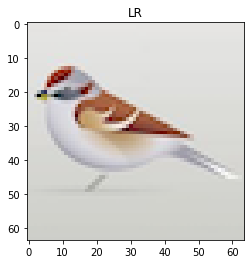

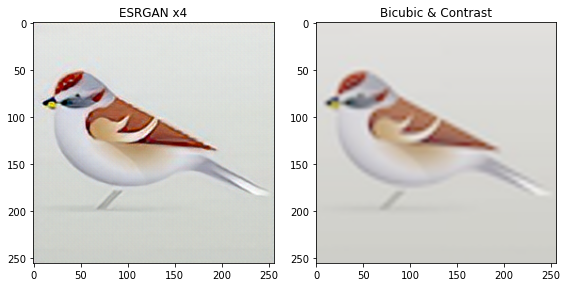

In [18]:
%run esrgantf2_superresolution.py
lr1,sr1=esrgantf2_superresolution(file_path+file_name1,64)
low2super_contrastbicubic(lr1,sr1)

352256/351359 [==============================] - 0s 1us/step


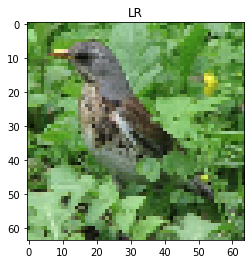

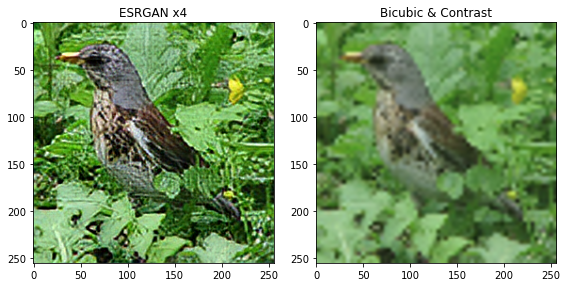

In [19]:
lr2,sr2=esrgantf2_superresolution(file_path+file_name2,64)
low2super_contrastbicubic(lr2,sr2)